In [ ]:
%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch
from IPython.display import display

from juart.conopt.functional.fourier import (
    nonuniform_fourier_transform_adjoint,
    nonuniform_fourier_transform_forward,
)
from juart.ellipsoid_phantoms.ellipsoids import SheppLogan

# 2D Non-uniform Fourier Transform

In [2]:
fov = [0.2, 0.2]
matrix = [256, 256]
echo_sig = [1, 0.7]

## Create Shepp-Logan phantom

In [3]:
phantom = SheppLogan(
    fov=fov,
    matrix=matrix,
)

image = phantom.get_object()

# Add echo signal decay
image = torch.concatenate([image * sig for sig in echo_sig], dim=2)

# Add channel dimension
image = image.unsqueeze(0)

# Add partition dimension
image = image.unsqueeze(3)

# Transform real image to complex image
image = torch.complex(image, torch.zeros_like(image))

# Scale image to have max magnitude of 1
image /= torch.max(torch.abs(image))

image_mag = torch.abs(image)

print(f"Object image size is {image.size()}")

Object image size is torch.Size([1, 256, 256, 1, 2])


IntSlider(value=0, description='Echo:', max=1)

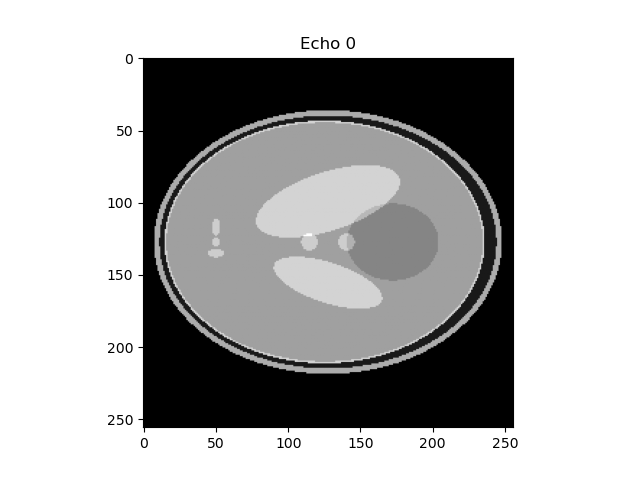

In [4]:
e_init = 0

fig = plt.figure()
shw = plt.imshow(image_mag[0, :, :, 0, e_init], cmap="gray")


def update_slice(e):
    shw.set_data(image_mag[0, :, :, 0, e])
    plt.title(f"Echo {e}")
    fig.canvas.draw()


e_slider = widgets.IntSlider(
    value=e_init, min=0, max=image_mag.shape[-1] - 1, step=1, description="Echo:"
)
widgets.interactive(update_slice, e=e_slider)
display(e_slider)

plt.show()

## Create arbitrary k-space trajectory from grid

Create a uniform grid with nyquist sample criterion in kspace and convert it to vector shape (dim, samples)

In [17]:
ktraj = [torch.arange(-m // 2, m // 2) / m for m, f in zip(matrix, fov)]
ktraj = torch.meshgrid(*ktraj, indexing="ij")
ktraj = torch.stack(ktraj, dim=0).view(2, -1)

print(f"K-space trajectory size is {ktraj.size()}")

K-space trajectory size is torch.Size([2, 65536])


## Calculate analytical kspace signal for given kspace locations

In [ ]:
ktraj_scale = ktraj.clone()
ktraj_scale[0] *= matrix[0] / fov[0]
ktraj_scale[1] *= matrix[1] / fov[1]
signal_anal = phantom.get_arb_kspace(ktraj_scale)

# Add channel dimension
signal_anal = signal_anal.unsqueeze(0)

# Add echo signal decay
signal_anal = torch.concatenate([signal_anal * sig for sig in echo_sig], dim=2)

print("Shape of data is", signal_anal.size())

Shape of data is torch.Size([1, 65536, 2])


## Calculate forward NUFFT

In [30]:
signal_num = nonuniform_fourier_transform_forward(k=ktraj, x=image)

# Scale signal_num to have max magnitude of 1
signal_num /= torch.max(torch.abs(signal_num))

print(f"Kspace signal_num size is {signal_num.size()}")
print(f"Number of Channels: {signal_num.shape[0]}")
print(f"Number of samples: {signal_num.shape[1]}")
print(f"Number of echoes: {signal_num.shape[2]}")

Kspace signal_num size is torch.Size([1, 65536, 2])
Number of Channels: 1
Number of samples: 65536
Number of echoes: 2


## Reconstruct to image space
Reshape signal to grid and calculate inverse fast fourier trafo

In [31]:
tuple(matrix)

(256, 256)

In [32]:
tuple(matrix)

(256, 256)

In [33]:
signal_num = signal_num.view(image.shape)

image_recon_num = torch.fft.ifftn(signal_num, dim=[1, 2, 3])

# Scale image to have max magnitude of 1
image_recon_num /= torch.max(torch.abs(image_recon_num))

image_recon_num_mag = torch.abs(image_recon_num)

image_recon_anal = nonuniform_fourier_transform_adjoint(
    k=ktraj, x=signal_anal, n_modes=tuple(matrix[:2])
)

image_recon_anal /= torch.max(torch.abs(image_recon_anal))

image_recon_anal_mag = torch.abs(image_recon_anal)

IntSlider(value=0, description='Echo:', max=1)

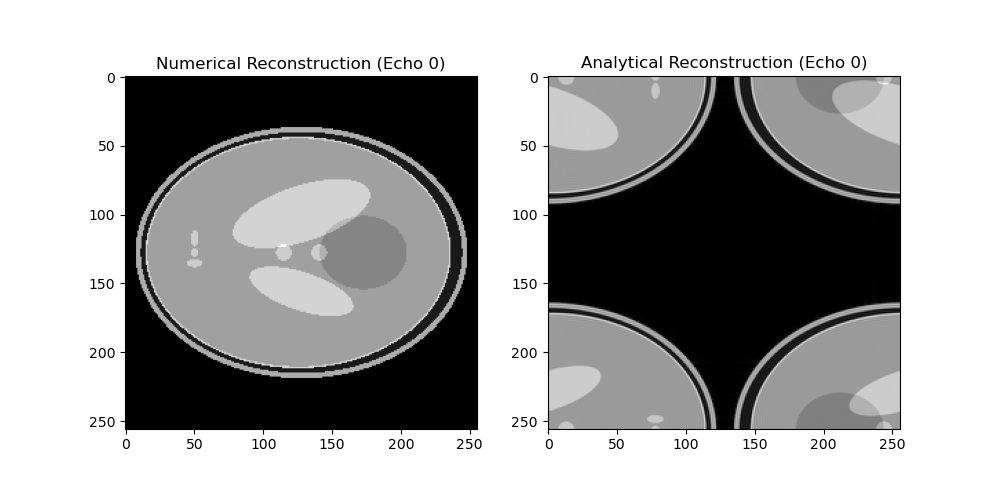

In [ ]:
e_init = 0

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display image_recon_num_mag
shw_num = axes[0].imshow(image_recon_num_mag[0, :, :, 0, e_init], cmap="gray")
axes[0].set_title("Numerical Reconstruction")

# Display image_recon_anal_mag
shw_anal = axes[1].imshow(image_recon_anal_mag[0, :, :, 0, e_init], cmap="gray")
axes[1].set_title("Analytical Reconstruction")


def update_slice(e):
    shw_num.set_data(image_recon_num_mag[0, :, :, 0, e])
    shw_anal.set_data(image_recon_anal_mag[0, :, :, 0, e])
    axes[0].set_title(f"Numerical Reconstruction (Echo {e})")
    axes[1].set_title(f"Analytical Reconstruction (Echo {e})")
    fig.canvas.draw()


e_slider = widgets.IntSlider(
    value=e_init,
    min=0,
    max=image_recon_num_mag.shape[-1] - 1,
    step=1,
    description="Echo:",
)

widgets.interactive(update_slice, e=e_slider)

display(e_slider)

# Forward 3D Non-uniform Fourier Transform

In [ ]:
fov = [0.2, 0.2, 0.2]
matrix = [256, 256, 256]
echo_sig = [1, 0.7]

## Create Shepp-Logan phantom

In [ ]:
phantom = SheppLogan(
    fov=fov,
    matrix=matrix,
)

image = phantom.get_object()

# Add echo signal decay
image = torch.concatenate([image * sig for sig in echo_sig], dim=3)

# Add channel dimension
image = image.unsqueeze(0)

# Transform real image to complex image
image = torch.complex(image, torch.zeros_like(image))

# Scale image to have max magnitude of 1
image /= torch.max(torch.abs(image))

image_mag = torch.abs(image)

print(f"Object image size is {image.size()}")

Object image size is torch.Size([1, 256, 256, 256, 2])


IntSlider(value=97, description='Slice:', max=255)

IntSlider(value=0, description='Echo:', max=1)

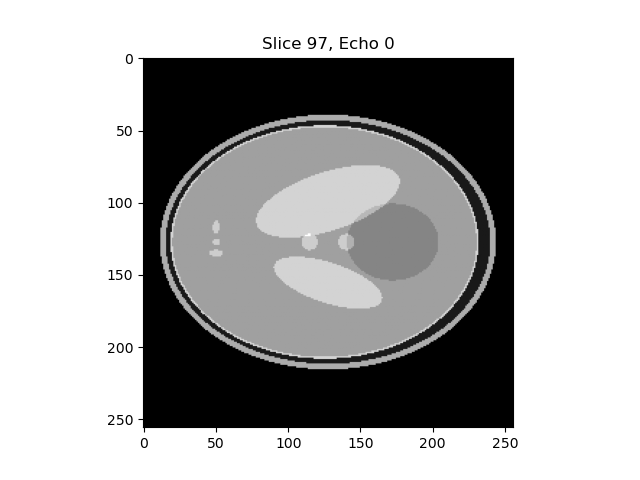

In [ ]:
z_init = int(image_mag.shape[2] * 0.38)
e_init = 0

fig = plt.figure()
shw = plt.imshow(image_mag[0, :, :, z_init, e_init], cmap="gray")


def update_slice(z, e):
    shw.set_data(image_mag[0, :, :, z, e])
    plt.title(f"Slice {z}, Echo {e}")
    fig.canvas.draw()


z_slider = widgets.IntSlider(
    value=z_init, min=0, max=image_mag.shape[-2] - 1, step=1, description="Slice:"
)
e_slider = widgets.IntSlider(
    value=e_init, min=0, max=image_mag.shape[-1] - 1, step=1, description="Echo:"
)
widgets.interactive(update_slice, z=z_slider, e=e_slider)
display(z_slider)
display(e_slider)

plt.show()

## Create arbitrary k-space trajectory from grid

Create a uniform grid with nyquist sample criterion in kspace and convert it to vector shape (dim, samples)

In [ ]:
ktraj = [torch.arange(-m // 2, m // 2) / m for m, f in zip(matrix, fov)]
ktraj = torch.meshgrid(*ktraj, indexing="ij")
ktraj = torch.stack(ktraj, dim=0).view(3, -1)

print(f"K-space trajectory size is {ktraj.size()}")

K-space trajectory size is torch.Size([3, 16777216])


## Calculate forwart NUFFT

In [ ]:
signal = nonuniform_fourier_transform_forward(k=ktraj, x=image)

# Scale signal to have max magnitude of 1
signal /= torch.max(torch.abs(signal))

print(f"Kspace signal size is {signal.size()}")
print(f"Number of Channels: {signal.shape[0]}")
print(f"Number of samples: {signal.shape[1]}")
print(f"Number of echoes: {signal.shape[2]}")

Kspace signal size is torch.Size([1, 16777216, 2])
Number of Channels: 1
Number of samples: 16777216
Number of echoes: 2


## Reconstruct to image space
Reshape signal to grid and calculate inverse fast fourier trafo

In [ ]:
signal = signal.view(image.shape)

image_recon = torch.fft.ifftn(signal, dim=[1, 2, 3])

# Scale image to have max magnitude of 1
image_recon /= torch.max(torch.abs(image_recon))

image_recon_mag = torch.abs(image_recon)

IntSlider(value=97, description='Slice:', max=255)

IntSlider(value=0, description='Echo:', max=1)

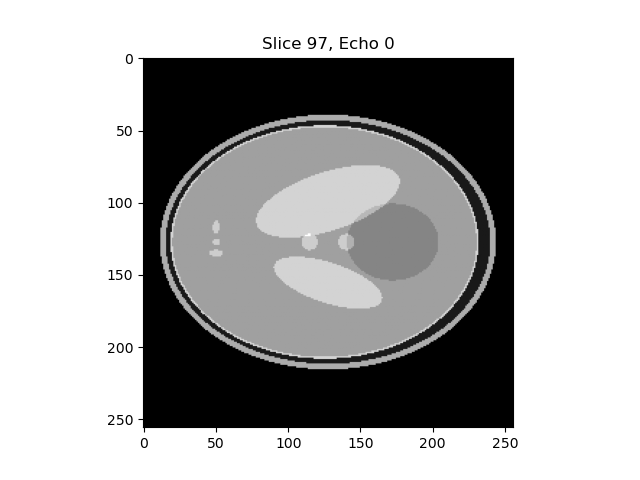

In [ ]:
z_init = int(image_recon_mag.shape[-2] * 0.38)
e_init = 0

fig = plt.figure()
shw = plt.imshow(image_recon_mag[0, :, :, z_init, e_init], cmap="gray")


def update_slice(z, e):
    shw.set_data(image_recon_mag[0, :, :, z, e])
    plt.title(f"Slice {z}, Echo {e}")
    fig.canvas.draw()


z_slider = widgets.IntSlider(
    value=z_init, min=0, max=image_recon_mag.shape[-2] - 1, step=1, description="Slice:"
)
e_slider = widgets.IntSlider(
    value=e_init, min=0, max=image_recon_mag.shape[-1] - 1, step=1, description="Echo:"
)

widgets.interactive(update_slice, z=z_slider, e=e_slider)
display(z_slider)
display(e_slider)